In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

from typing import List, Tuple, Dict
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [69]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data
    

    def KPS_Solution(self, dwt) -> Tuple[np.ndarray, np.ndarray]:
        """
            This functions implemets KPS (Kloden-Platen-Schurz-Sorensen) method,

            having b_x, b_xx, sigma_x, sigma_xx - partial derivatives of the 
            drift and diffusion coeffitients b(t, x), sigma(t, x) with respect to x,

        """
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        # Generate second-order increments dUt
        dut = np.random.normal(0, np.sqrt(dt**3 / 3), (self.Nt, self.Nx))

        for i in range(1, self.Nt + 1):
            # Current state
            xi = x_data[i - 1]

            # Wiener increment and second-order random variable
            dW = dwt[i - 1]
            dU = dut[i - 1]

            # Drift and volatility terms
            b = self.bxt(xi)
            sigma = self.sigmaxt(xi) # Diffusion coef
            sigma_x = self.sigmaxt_x(xi) # First derivative of the diffusion
            sigma_xx = self.sigmaxt_xx(xi) # Second derivative of the diffusion

            # Higher-order terms for the KPS method
            b_x = self.bxt_x(xi)  # First derivative of the drift
            b_xx = self.bxt_xx(xi) # Second derivative of the drift

            # b * dt
            term1 = b * dt
            # sigma * dW_t
            term2 = sigma * dW
            # 1/2 * sigma *dsigma/dx * (dW_t ** 2 - dt)
            term3 = 0.5 * sigma * sigma_x * (dW**2 - dt)
            # sigma * db/dx * dU_t
            term4 = sigma * b_x * dU
            # 1/2 * (b * db/dx + 1/2 * sigma^2 * d^2b/dx^2) * dt^2
            term5 = 0.5 * (b * b_x + 0.5 * sigma**2 * b_xx) * dt**2
            # (b * dsigma/dx + 1/2 * sigma^2 * d^2sigma/dx^2) * (dW_t * dt - dU_t)
            term6 = (b * sigma_x + 0.5 * sigma ** 2 * sigma_xx) * (dW * dt - dU)
            # 1/2 * sigma ((dsigma/dx)^2 + sigma * d^2sigma/dx^2) * (1/3  dW^2_t - dt) * dW_t
            term7 = 0.5 * sigma * (sigma_x**2 + sigma * sigma_xx) * (dW**2 / 3 - dt) * dW

            # Update the process using KPS formula
            x_data[i] = xi + term1 + term2 + term3 + term4 + term5 + term6 + term7

        return t_data, x_data

class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [4]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

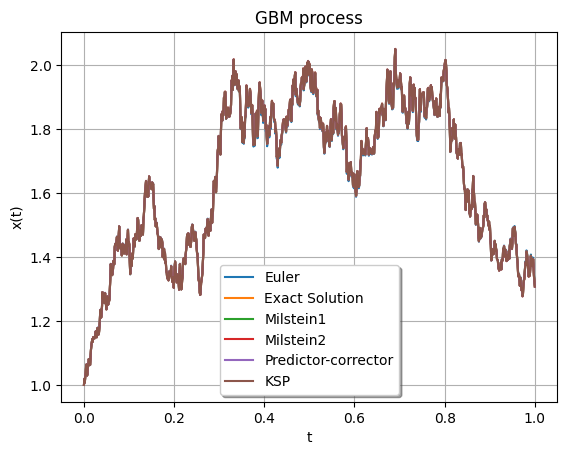

In [9]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

t_data, x_data = BSMp.KPS_Solution(dwt)
plt.plot(t_data, x_data, label = 'KSP')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [10]:
def run_factory(discretization_state: int, model: StochasticProcess):
    """
        runs all approximation calculations for a given model with a certain 
        discretization state

        Arguments:
            discretization_state, int - represents the discetization level, i.e. the number of steps 
                    the timeline is devided to
            model, StochasticProcess - a model that inherits base model, i.g. BSM

        Returns:
            approximations, Dict[str, Dict[str, np.ndarray]] - a dict of results, with a 
                    name of approximation methed as a key, and a dict on time points and process 
                    points as a value

                    for example:
                    
                    {'exact': {'t_data': t_data, 'x_data': x_data}}
    """

    # generate Wiener process steps
    dwt = np.random.normal(0, 1, size = (model.Nt, model.Nx)) * np.sqrt(model.T/model.Nt)

    # make the container
    approximations = {}

    # calculate the exact solution
    t_data, x_data = model.ExactSolution(dwt)
    approximations['exact'] = {'t_data': t_data, 'x_data': x_data}

    # approximate via Euler method
    t_data, x_data = model.EulerSolution(dwt)
    approximations['euler'] = {'t_data': t_data, 'x_data': x_data}

    # approximate via the first Milstain scheme
    t_data, x_data = model.Milstein1Solution(dwt)
    approximations['milstein1'] = {'t_data': t_data, 'x_data': x_data}

    # approximate via the second Milstein scheme
    t_data, x_data = model.Milstein2Solution(dwt)
    approximations['milstein2'] = {'t_data': t_data, 'x_data': x_data}

    # approximate via PredictiorCorrector Solution
    t_data, x_data = model.PredictorCorrectorSolution(dwt, 1/2, 1/2)
    approximations['Predictor-corrector'] = {'t_data': t_data, 'x_data': x_data}

    # approximate via Kloden-Platen-Schurz-Sorensen method
    t_data, x_data = model.KPS_Solution(dwt)
    approximations['KSP'] = {'t_data': t_data, 'x_data': x_data}

    return approximations

In [64]:
T = 1
Nx = 1
# Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

theta1 = 1
theta2 = 1/2
params = [theta1, theta2]


Ns = [2, 4, 8, 128, 256, 1024, 8192, 16384, 32768]

result = {}


for Nt in tqdm(Ns):
    dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

    BSMp = BSMprocess(params, T, Nx, Nt, init_state)

    result[Nt] = run_factory(Nt, BSMp)

100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


In [56]:
def pack_results_into_DataFame(results: dict) -> pd.DataFrame:

    diffs = []
    for N, res in results.items():
        exact = res['exact']['x_data']
        for name, data in res.items():
            if name == 'exact':
                continue
            diff = np.abs(data['x_data'] - exact)
            diffs.append([name, N, diff.min(), diff.max(), diff.mean()])

    return pd.DataFrame(diffs, columns=['name', 'discretization', 'min', 'max', 'mean'])

In [30]:
exp_df = pack_results_into_DataFame(result)

In [31]:
exp_df

,name,discretization,min,max,mean
0,euler,2,0.0,3.686987e-01,1.540234e-01
1,milstein1,2,0.0,5.486408e-01,2.339403e-01
2,milstein2,2,0.0,1.951789e-02,9.341232e-03
3,Predictor-corrector,2,0.0,4.436018e-02,1.792408e-02
4,KSP,2,0.0,3.985911e-03,1.645533e-03
5,euler,4,0.0,2.071680e-01,1.294578e-01
6,milstein1,4,0.0,1.998690e-01,9.364826e-02
7,milstein2,4,0.0,2.661862e-02,1.969764e-02
8,Predictor-corrector,4,0.0,3.900945e-02,3.019307e-02
9,KSP,4,0.0,2.806547e-02,1.487199e-02


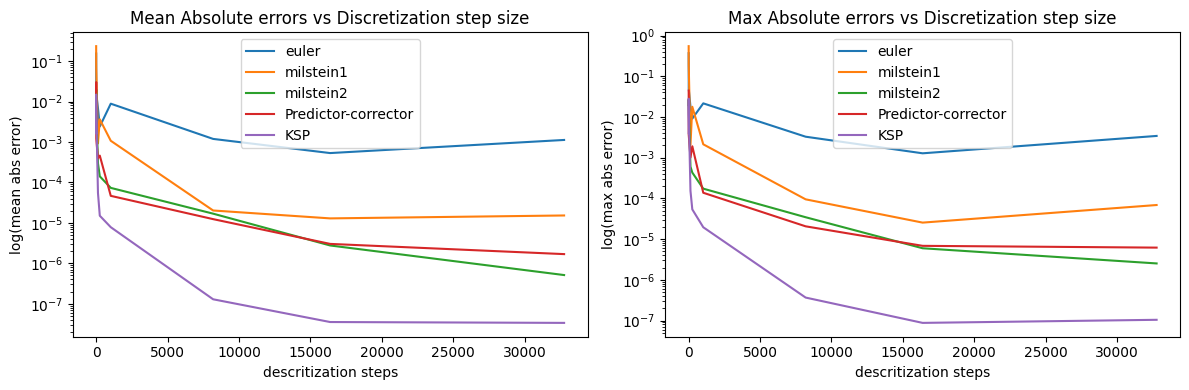

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for name in exp_df.name.unique():
    means = exp_df[exp_df.name == name]['mean'].to_list()
    desc = exp_df[exp_df.name == name].discretization.to_list()

    axs[0].plot(desc, means, label=name)

axs[0].set_yscale('log')
axs[0].set_xlabel('descritization steps')
axs[0].set_ylabel('log(mean abs error)')
axs[0].set_title('Mean Absolute errors vs Discretization step size')
axs[0].legend()

for name in exp_df.name.unique():
    means = exp_df[exp_df.name == name]['max'].to_list()
    desc = exp_df[exp_df.name == name].discretization.to_list()

    axs[1].plot(desc, means, label=name)

axs[1].set_yscale('log')
axs[1].set_xlabel('descritization steps')
axs[1].set_ylabel('log(max abs error)')
axs[1].set_title('Max Absolute errors vs Discretization step size')
axs[1].legend()


plt.tight_layout()
plt.show()

Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



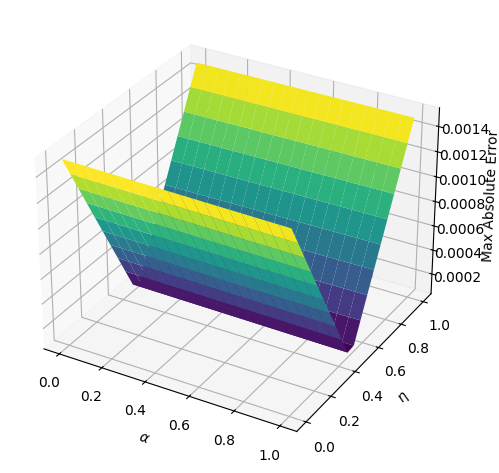

In [52]:
# your code
# Study influence of alpha and eta
def study_alpha_eta(processModel: BSMprocess, alphas: np.ndarray, etas: np.ndarray):
    """
    
    """
    dt = processModel.T / processModel.Nt
    dwt = np.random.normal(0, 1, size = (processModel.Nt, processModel.Nx)) * np.sqrt(dt)

    _, exact_solution = processModel.ExactSolution(dwt)
    
    # Store errors for different alpha and eta values
    errors = np.zeros((len(alphas), len(etas)))

    for i, alpha in enumerate(alphas):
        for j, eta in enumerate(etas):
            _, approx_solution = processModel.PredictorCorrectorSolution(dwt, eta=eta, alpha=alpha)
            # print(exact_solution.shape, approx_solution.shape)
            errors[i, j] = np.max(np.abs(exact_solution - approx_solution))
    
    return errors

# Plot 3D error surface
def plot_error_surface(alphas, etas, errors):
    alpha_grid, eta_grid = np.meshgrid(alphas, etas)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha_grid, eta_grid, errors.T, cmap='viridis')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\eta$')
    ax.set_zlabel('Max Absolute Error')
    plt.tight_layout()
    plt.show()

# Parameters
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
params = [r, sigma]
T = 1.0  # time horizon
Nx = 1  # number of assets
Nt = 1000  # number of time steps

# Define a range of alpha and eta values
alphas = np.linspace(0, 1, 20)
etas = np.linspace(0, 1, 20)

# Study the influence of alpha and eta on the solution accuracy
errors = study_alpha_eta(BSMprocess(params, T, Nx, Nt), alphas, etas)

# Plot the results
plot_error_surface(alphas, etas, errors)

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

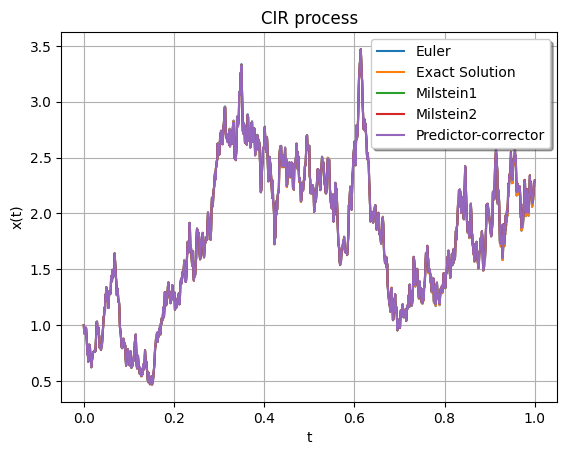

In [65]:
T = 1
Nx = 1
Nt = 1024

theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

In [66]:
Ns = [2, 4, 8, 128, 256, 1024, 8192, 16384, 32768]

result = {}


for Nt in tqdm(Ns):

    result[Nt] = run_factory(Nt, CIRp)

100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


In [67]:
cir_df = pack_results_into_DataFame(result)
cir_df.head()

,name,discretization,min,max,mean
0,euler,2,0.0,0.002805,0.000982
1,milstein1,2,0.0,0.032079,0.012330
2,milstein2,2,0.0,0.031286,0.012141
3,Predictor-corrector,2,0.0,0.031097,0.012214
4,KSP,2,0.0,0.031448,0.012459


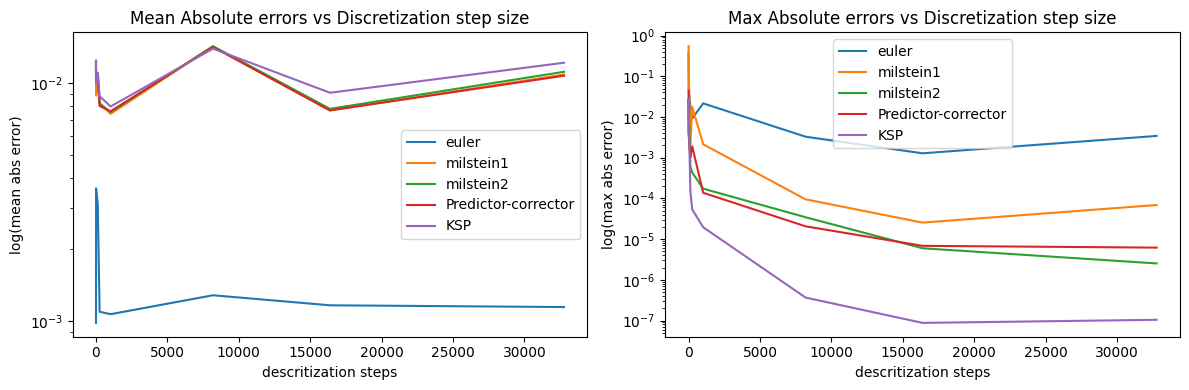

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for name in cir_df.name.unique():
    means = cir_df[cir_df.name == name]['mean'].to_list()
    desc = cir_df[cir_df.name == name].discretization.to_list()

    axs[0].plot(desc, means, label=name)

axs[0].set_yscale('log')
axs[0].set_xlabel('descritization steps')
axs[0].set_ylabel('log(mean abs error)')
axs[0].set_title('Mean Absolute errors vs Discretization step size')
axs[0].legend()

for name in exp_df.name.unique():
    means = exp_df[exp_df.name == name]['max'].to_list()
    desc = exp_df[exp_df.name == name].discretization.to_list()

    axs[1].plot(desc, means, label=name)

axs[1].set_yscale('log')
axs[1].set_xlabel('descritization steps')
axs[1].set_ylabel('log(max abs error)')
axs[1].set_title('Max Absolute errors vs Discretization step size')
axs[1].legend()


plt.tight_layout()
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [59]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

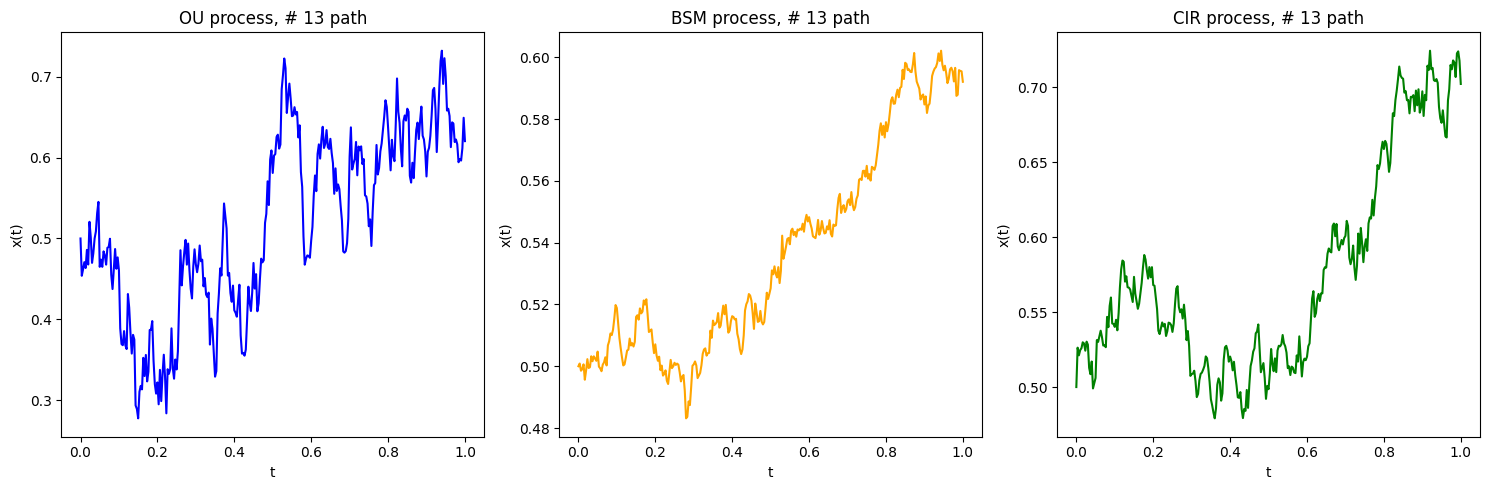

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

# Modified CIR model

$$dX_t = -\theta_1 X_tdt + \theta_2\sqrt{1 + X_t^2}dW_t$$

$$b(t, x) = -\theta_1 X_t$$

$$b_x = -\theta_1$$
$$b_{xx} = 0$$


$$\sigma(t, x) = \theta_2\sqrt{1 + X^2}$$

$$\sigma_x = \theta_2\frac{x}{\sqrt{(1 + x^2)}}$$

$$\sigma_{xx} = \theta_2 \frac{1}{(1 + x^2)^{\frac{3}{2}}} $$



with a stationary distribution propotional to:

$$\frac{1}{(1 + x^2)^{1 + \frac{\theta_1}{\theta_2^2}}}$$

applying $\nu = 1 + \frac{2\theta_1}{\theta_2^2}$ we'll get $X_t \sim t(\nu) / \sqrt(\nu)$, having $t(\nu)$ - the Student distribution with $\nu$ degrees of freedom


In [123]:
from scipy.stats import t, uniform

class ModifiedCIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: - self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * np.sqrt(1 * x**2)
        self.bxt_x = lambda x: - self.params[0]
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: self.params[1] * x / np.sqrt((1 + x**2))
        self.sigmaxt_xx = lambda x: self.params[1] * 1 / (1 + x**2)**1.5

    def DefaultInitState(self):
        return - np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]

        # Degrees of freedom for the t-distribution
        nu = 1 + (2 * theta1) / (theta2**2)

        # Sample from Student's t-distribution with nu degrees of freedom
        result = t.rvs(df=nu, size=self.Nx) / np.sqrt(nu)
        return result

    def SampleFromDensity(self, x0, t1, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]

        # Degrees of freedom for the t-distribution
        nu = 1 + (2 * theta1) / (theta2**2)
        
        # Time decay factor
        decay_factor = np.exp(-theta1 * (t1 - t0))
        
        # Perform rejection sampling to generate samples
        result = np.zeros(self.Nx)
        for j in range(self.Nx):
            accept = False
            while not accept:
                # Sample from the proposal distribution t(nu) / sqrt(nu)
                x_candidate = t.rvs(df=nu) / np.sqrt(nu)
                
                # Compute the target density ratio for acceptance
                target_density = 1 / (1 + x_candidate**2)**(1 + theta1 / theta2**2)
                proposal_density = t.pdf(x_candidate, df=nu) / np.sqrt(nu)
                acceptance_ratio = target_density / proposal_density

                # Rejection step
                if uniform.rvs() < acceptance_ratio:
                    result[j] = x_candidate * decay_factor
                    accept = True

        return result

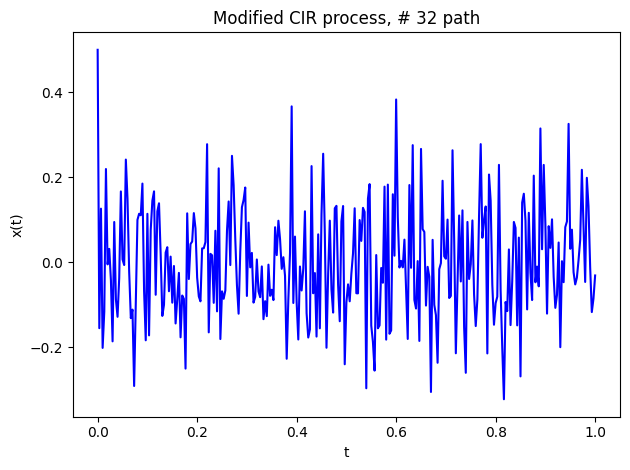

In [124]:
Nx = 100
Nt = 300

T = 1

params_ModCIR = [0.3, 0.1]

init_state = 0.5 * np.ones(Nx)

ModCIR = ModifiedCIRprocess(params_ModCIR, T, Nx, Nt, init_state)

t_data, x_data_ModCIR = ModCIR.PathGenerator()

n = np.random.randint(0, Nx)

plt.plot(t_data, x_data_ModCIR[:,n], color='blue')
plt.title(f'Modified CIR process, # {n} path')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [119]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

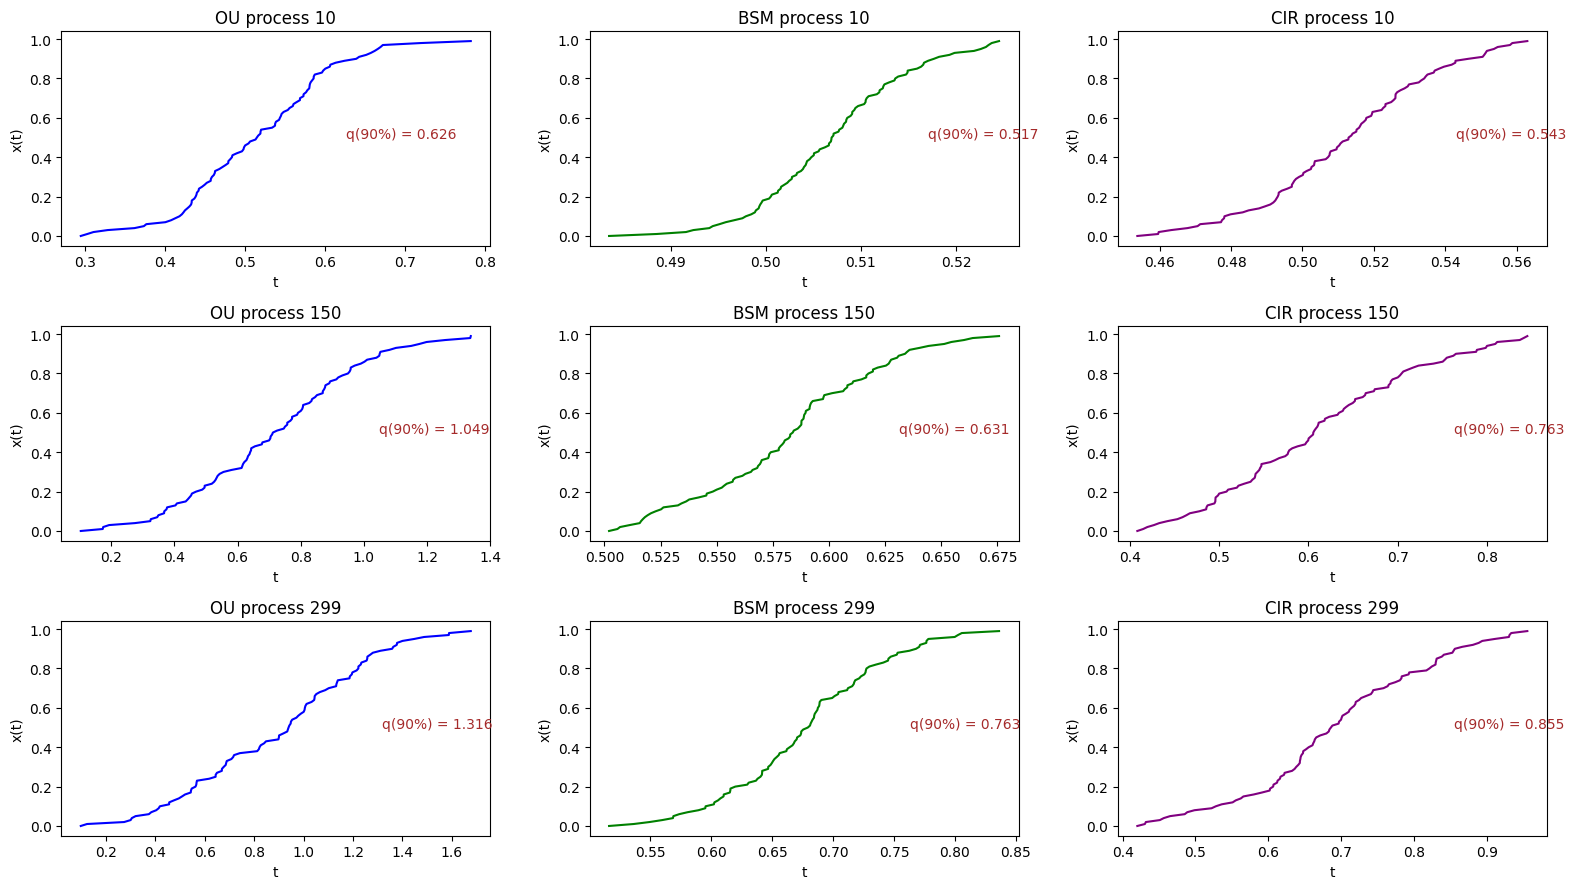

In [120]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

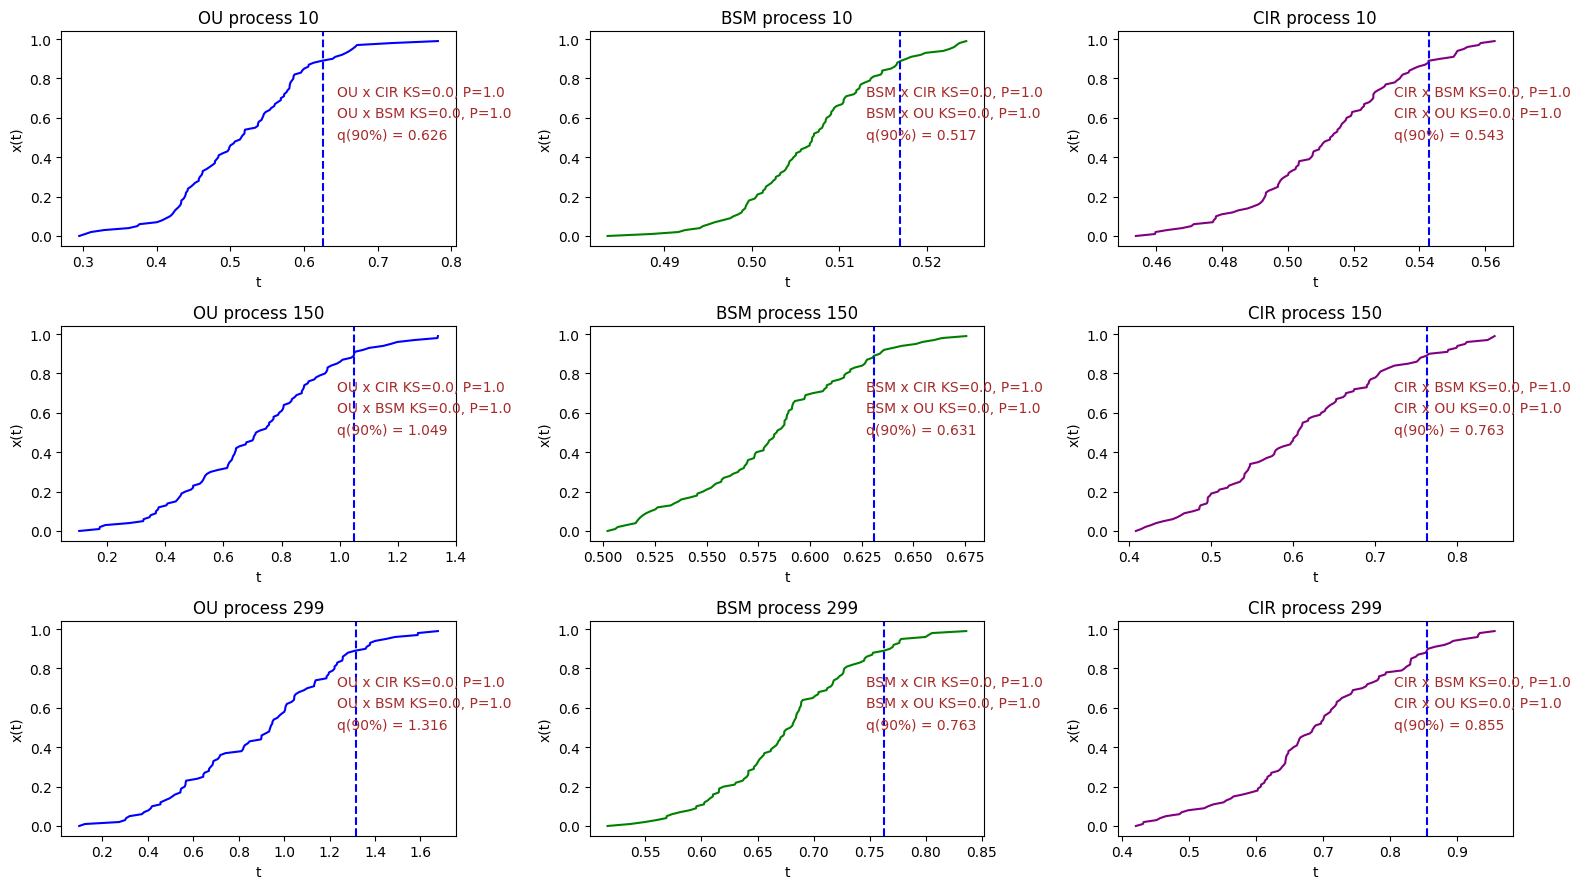

In [144]:
# your code
from scipy.stats import ks_2samp

#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

margin = 0.7

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[0][0].transAxes)
axs[0][0].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[0][0].text(margin, 0.6, f"OU x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][0].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[0][0].text(margin, 0.7, f"OU x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][0].transAxes)

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[0][1].transAxes)
axs[0][1].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_OU[n])[-1])
axs[0][1].text(margin, 0.6, f"BSM x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][1].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[0][1].text(margin, 0.7, f"BSM x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][1].transAxes)

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[0][2].transAxes)
axs[0][2].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_OU[n])[-1])
axs[0][2].text(margin, 0.6, f"CIR x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][2].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[0][2].text(margin, 0.7, f"CIR x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[0][2].transAxes)

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[1][0].transAxes)
axs[1][0].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[1][0].text(margin, 0.6, f"OU x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][0].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[1][0].text(margin, 0.7, f"OU x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][0].transAxes)

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[1][1].transAxes)
axs[1][1].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_OU[n])[-1])
axs[1][1].text(margin, 0.6, f"BSM x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][1].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[1][1].text(margin, 0.7, f"BSM x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][1].transAxes)

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[1][2].transAxes)
axs[1][2].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_OU[n])[-1])
axs[1][2].text(margin, 0.6, f"CIR x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][2].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[1][2].text(margin, 0.7, f"CIR x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[1][2].transAxes)

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[2][0].transAxes)
axs[2][0].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[2][0].text(margin, 0.6, f"OU x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][0].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_OU[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[2][0].text(margin, 0.7, f"OU x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][0].transAxes)

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[2][1].transAxes)
axs[2][1].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_OU[n])[-1])
axs[2][1].text(margin, 0.6, f"BSM x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][1].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_BSM[n])[-1], ecdf(x_data_CIR[n])[-1])
axs[2][1].text(margin, 0.7, f"BSM x CIR KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][1].transAxes)

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(margin, 0.5, f"q(90%) = {val}", color = 'brown', transform=axs[2][2].transAxes)
axs[2][2].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_OU[n])[-1])
axs[2][2].text(margin, 0.6, f"CIR x OU KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][2].transAxes)
ks_stat, p_value = ks_2samp(ecdf(x_data_CIR[n])[-1], ecdf(x_data_BSM[n])[-1])
axs[2][2].text(margin, 0.7, f"CIR x BSM KS={ks_stat}, P={p_value}", color = 'brown', transform=axs[2][2].transAxes)

for k in range(0, 3):
    for j in range(0, 3):
        # axs[k][j].set_ylim(0, 1)
        # axs[k][j].set_xlim(0, 1)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Null Hypothesis (H0):

    - One-sample test: The sample follows the reference distribution.
    - Two-sample test: Both samples come from the same underlying distribution.



Alternative Hypothesis (H1):

    - One-sample test: The sample does not follow the reference distribution.
    - Two-sample test: The two samples come from different distributions.



Output of the K-S Test

    - K-S statistic (D-value): The maximum difference between the two CDFs. Larger values suggest greater differences.
    - P-value: The probability of observing such a difference under the null hypothesis. A small p-value (e.g., < 0.05) indicates that the null hypothesis can be rejected, implying the two distributions are significantly different.

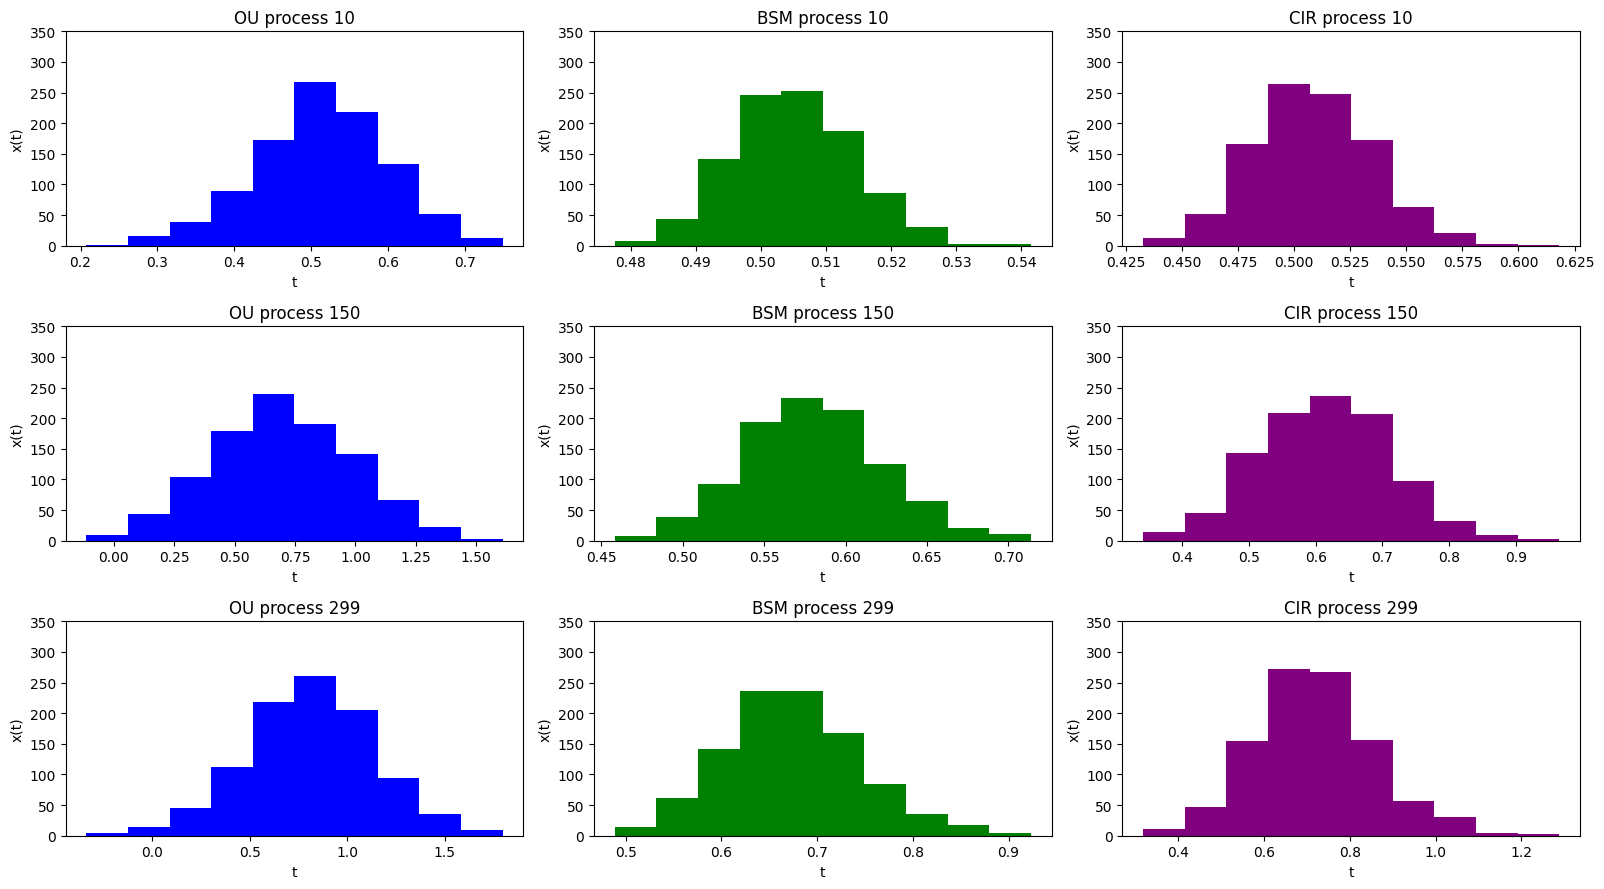

In [ ]:
#density function
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

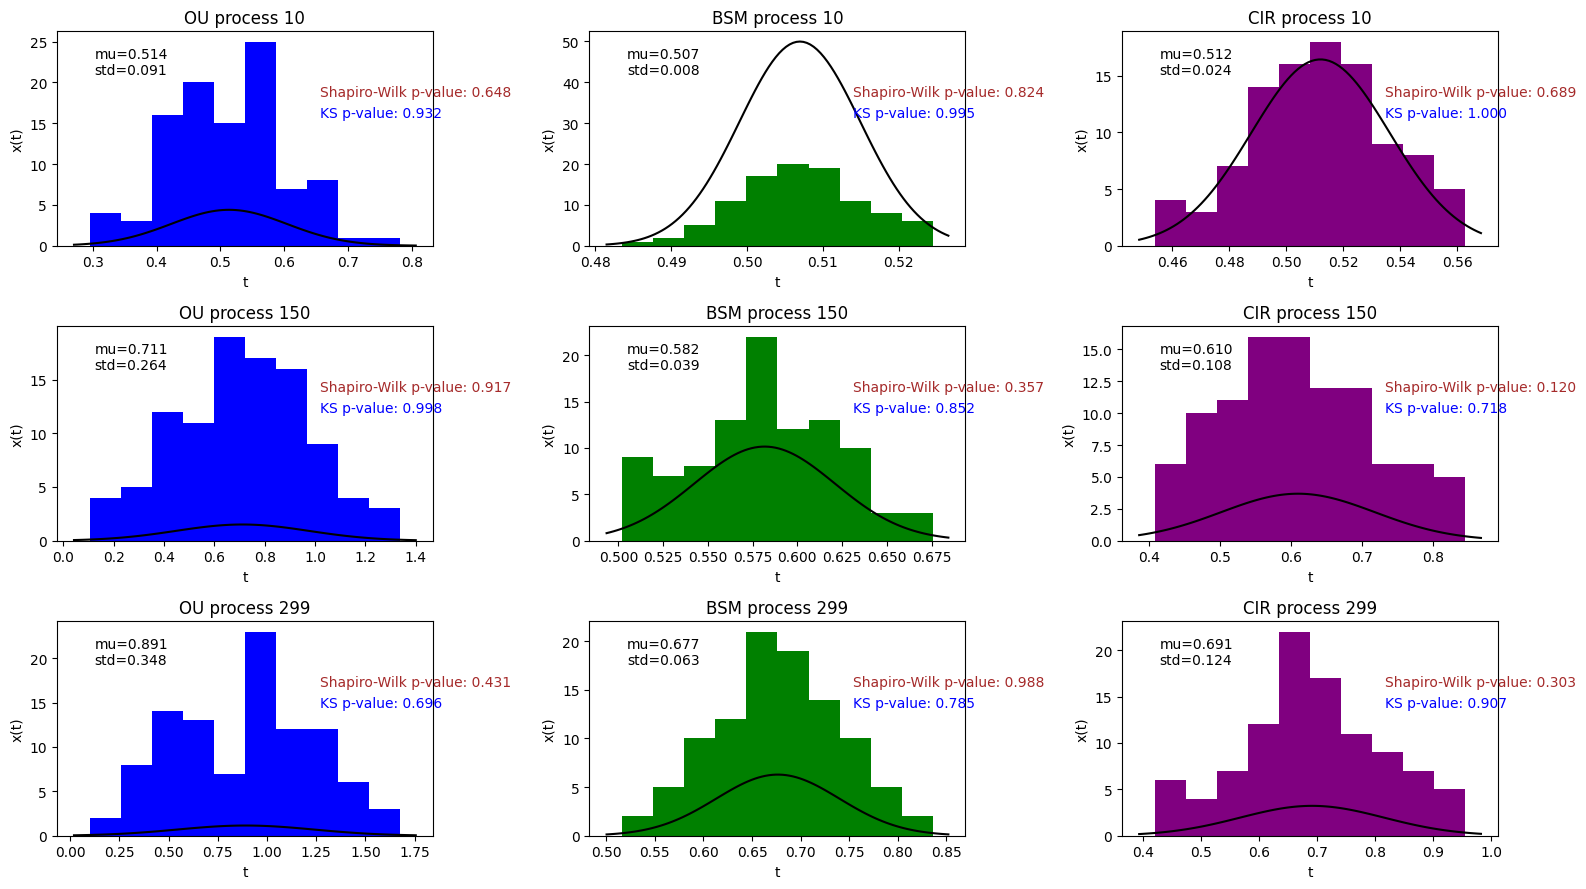

In [172]:
# your code
#density function
from scipy.stats import norm, shapiro, kstest


fig, axs = plt.subplots(3, 3, figsize=(16, 9))

ns = [10, Nt // 2, Nt - 1]
models = [x_data_OU, x_data_BSM, x_data_CIR]
names = ['OU', 'BSM', 'CIR']
colors = ['blue', 'green', 'purple']

for k, n in enumerate(ns):
    for j, (model, model_name, color) in enumerate(zip(models, names, colors)):
        axs[k][j].hist(model[n], color=color)
        mu, std = norm.fit(model[n])
        
        xmin, xmax = axs[k][j].get_xlim()
        x = np.linspace(xmin, xmax, len(model[n]))
        p = norm.pdf(x, mu, std)
        axs[k][j].plot(x, p, color='black') # , label=f'mu={mu:.3f} | std={std:.3f}')
        axs[k][j].text(0.1, 0.8, f'mu={mu:.3f}\nstd={std:.3f}', color='black', 
                       transform=axs[k][j].transAxes)

        # Shapiro test
        stat, p_value = shapiro(model[n])
        axs[k][j].text(0.7, 0.7, f'Shapiro-Wilk p-value: {p_value:.3f}', color='brown' , 
                       transform=axs[k][j].transAxes)
        
        # Kolmogorov test
        ks_stat, ks_p_value = kstest(model[n], 'norm', args=(mu, std))
        axs[k][j].text(0.7, 0.6, f'KS p-value: {ks_p_value:.3f}', color='blue',  
                       transform=axs[k][j].transAxes)

        axs[k][j].set_title(f'{model_name} process {n}')
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')
        # axs[k][j].legend()

plt.tight_layout()

plt.show()